# Optimal control for linear dynamical systems and quadratic cost

In [20]:
# a few packages we need to import

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

## Finite horizon Linear Quadratic Regulator

Here we discuss the problem of computing the optimal control policy for problems of the form
$$ \min_{\mathbf{u}_n} \sum_{n=0}^{N-1} (\mathbf{x}_{n}^T \mathbf{Q}_n \mathbf{x}_n + \mathbf{u}_n^T \mathbf{R}_n \mathbf{u}_n) + \mathbf{x}_N^T \mathbf{Q}_N \mathbf{x}_N$$
subject to the deterministic linear dynamics  $$\mathbf{x}_{n+1} = \mathbf{A}_n \mathbf{x}_n + \mathbf{B}_n \mathbf{u}_n$$
where $\mathbf{R}>0$ (i.e. $\mathbf{R}$ is a positive definite matrix) and $\mathbf{Q} \geq 0$.

Applying the dynamic programming principle, one can find the cost-to-go and optimal policy at every stage by solving the following backward recurrence equations from $N$ to $0$ (backward Riccati equations):
1. Set $\mathbf{P}_N = \mathbf{Q}_N$
2. Then compute recursively from $N-1$ to $0$:
$$\mathbf{K}_n = -(\mathbf{R}_n+\mathbf{B}_n^T \mathbf{P}_{n+1} \mathbf{B}_n)^{-1} (\mathbf{B}_n^T \mathbf{P}_{n+1} \mathbf{A}_n)\\
\mathbf{P}_n = \mathbf{Q}_n + \mathbf{A}_n^T \mathbf{P}_{n+1} \mathbf{A}_n + \mathbf{A}_n^T \mathbf{P}_{n+1} \mathbf{B}_n \mathbf{K}_n$$

For every stage, the cost-to-go is $$J_n(\mathbf{x}_n) = \mathbf{x}_n^T \mathbf{P}_n \mathbf{x}_n$$
and the optimal policy is $$\mu_n^*(\mathbf{x}_n) = \mathbf{K}_n \mathbf{x}_n$$

The optimal value function is the cost-to-go at stage 0 $$J_0(\mathbf{x}_0) = \mathbf{x}_0^T \mathbf{P}_0 \mathbf{x}_0$$

## Solving the Riccati equations backward
The function below is a simple example on how to solve these Riccati equations for constant $\mathbf{A}$, $\mathbf{B}$, $\mathbf{Q}$ and $\mathbf{R}$

In [21]:
def solve_ricatti_equations(A,B,Q,R,horizon_length):
    """
    This function solves the backward Riccatti equations for regulator problems of the form
    min sum(xQx + uRu) + xQx subject to xn+1 = Axn + Bun
    
    Arguments:
    A, B, Q, R: numpy arrays defining the problem
    horizon_length: length of the horizon
    
    Returns:
    P: list of numpy arrays containing Pn from 0 to N
    K: list of numpy arrays containing Kn from 0 to N-1
    """
    P = [] #will contain the list of Ps from N to 0
    K = [] #will contain the list of Ks from N-1 to 0

    P.append(Q) #PN
    
    for i in range(horizon_length):
        Knew = -1.0 * np.linalg.inv(B.transpose().dot(P[i]).dot(B) + R).dot(B.transpose()).dot(P[i]).dot(A)
        Pnew = Q + A.transpose().dot(P[i]).dot(A) + A.transpose().dot(P[i]).dot(B).dot(Knew)
        K.append(Knew)
        P.append(Pnew)
    
    # since we went backward we return reverted lists
    return P[::-1],K[::-1]

## Simulating the dynamics
The function below simulates the dynamics of the system for constant $\mathbf{A}$ and $\mathbf{B}$. It assumes the system starts at a state $\mathbf{x}_0$, that we computed feedback matrices $\mathbf{K}_n$ for a certain horizon.

In [22]:
def simulate_dynamics(x0, A, B, K, horizon_length):
    """
    This function integrates the dynamic system Ax + Bu for horizon_length steps using the controllers
    defined in the list K
    
    Arguments:
    x0: numpy vector, initial value for x
    A,B: numpy arrays defining the dynamics
    K: list of feedback gains (list of length horizon_length)
    horizon_length: lenght of the horizon to integrate
    
    Returns:
    x a numpy array containing the integration result
    u a numpy array containing the control at each step
    """
        
    x=np.empty([len(x0), horizon_length+1])
    x[:,0] = x0
    
    u=np.empty([1, horizon_length])

    for i in range(horizon_length):
        u[:,i] = K[i].dot(x[:,i])
        x[:,i+1] = A.dot(x[:,i]) + B.dot(u[:,i])
    return x, u

## Example: a one dimensional linear system

Here we show how a simple example (shown in class) for the following one-dimensional linear system
$$x_{n+1} = 2x_n + u_n$$

In [23]:
# we define the dynamics
A = np.array([[2.]])
B = np.array([[1.]])

We now define a quadratic cost function $$\sum_{n=0}^{9} 2x_n^2 + u_n^2 + 2x_{10}^2$$ i.e. we set $Q=2$ and $R=1$.

In [24]:
Q = np.array([[2.]])
R = np.array([[1.]])

horizon_length = 10

We can now compute the optimal control gains and cost-to-go as follows

<IPython.core.display.Javascript object>


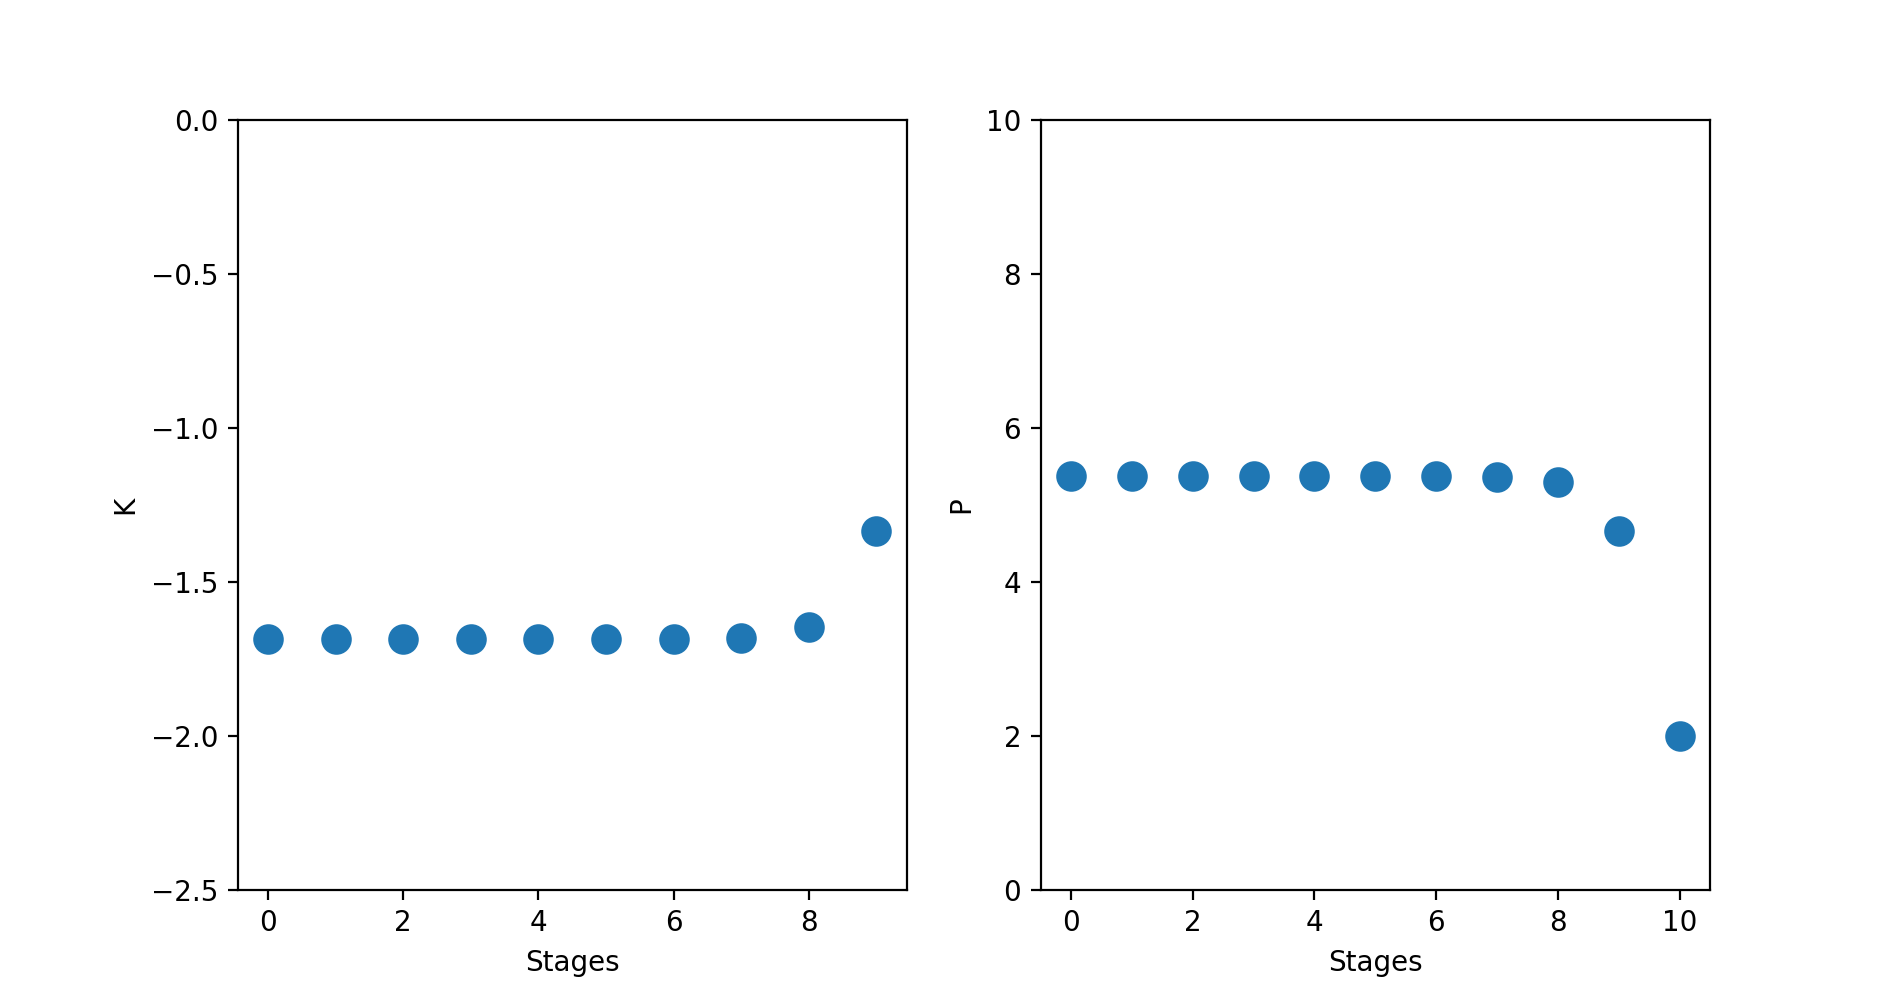

(0, 10)

In [25]:
# we find the optimal control
P,K = solve_ricatti_equations(A,B,Q,R,horizon_length)

# we can plot the computed gain
plt.figure(figsize=[9.5,5])
plt.subplot(1,2,1)
plt.plot(np.array(K).flatten(),'o', markersize=10)
plt.ylim([-2.5,0])
plt.xlabel('Stages')
plt.ylabel('K')

# we also plot P
plt.subplot(1,2,2)
plt.plot(np.array(P).flatten(),'o', markersize=10)
plt.xlabel('Stages')
plt.ylabel('P')
plt.ylim([0,10])

we can now simulate the dynamics and plot the results

<IPython.core.display.Javascript object>


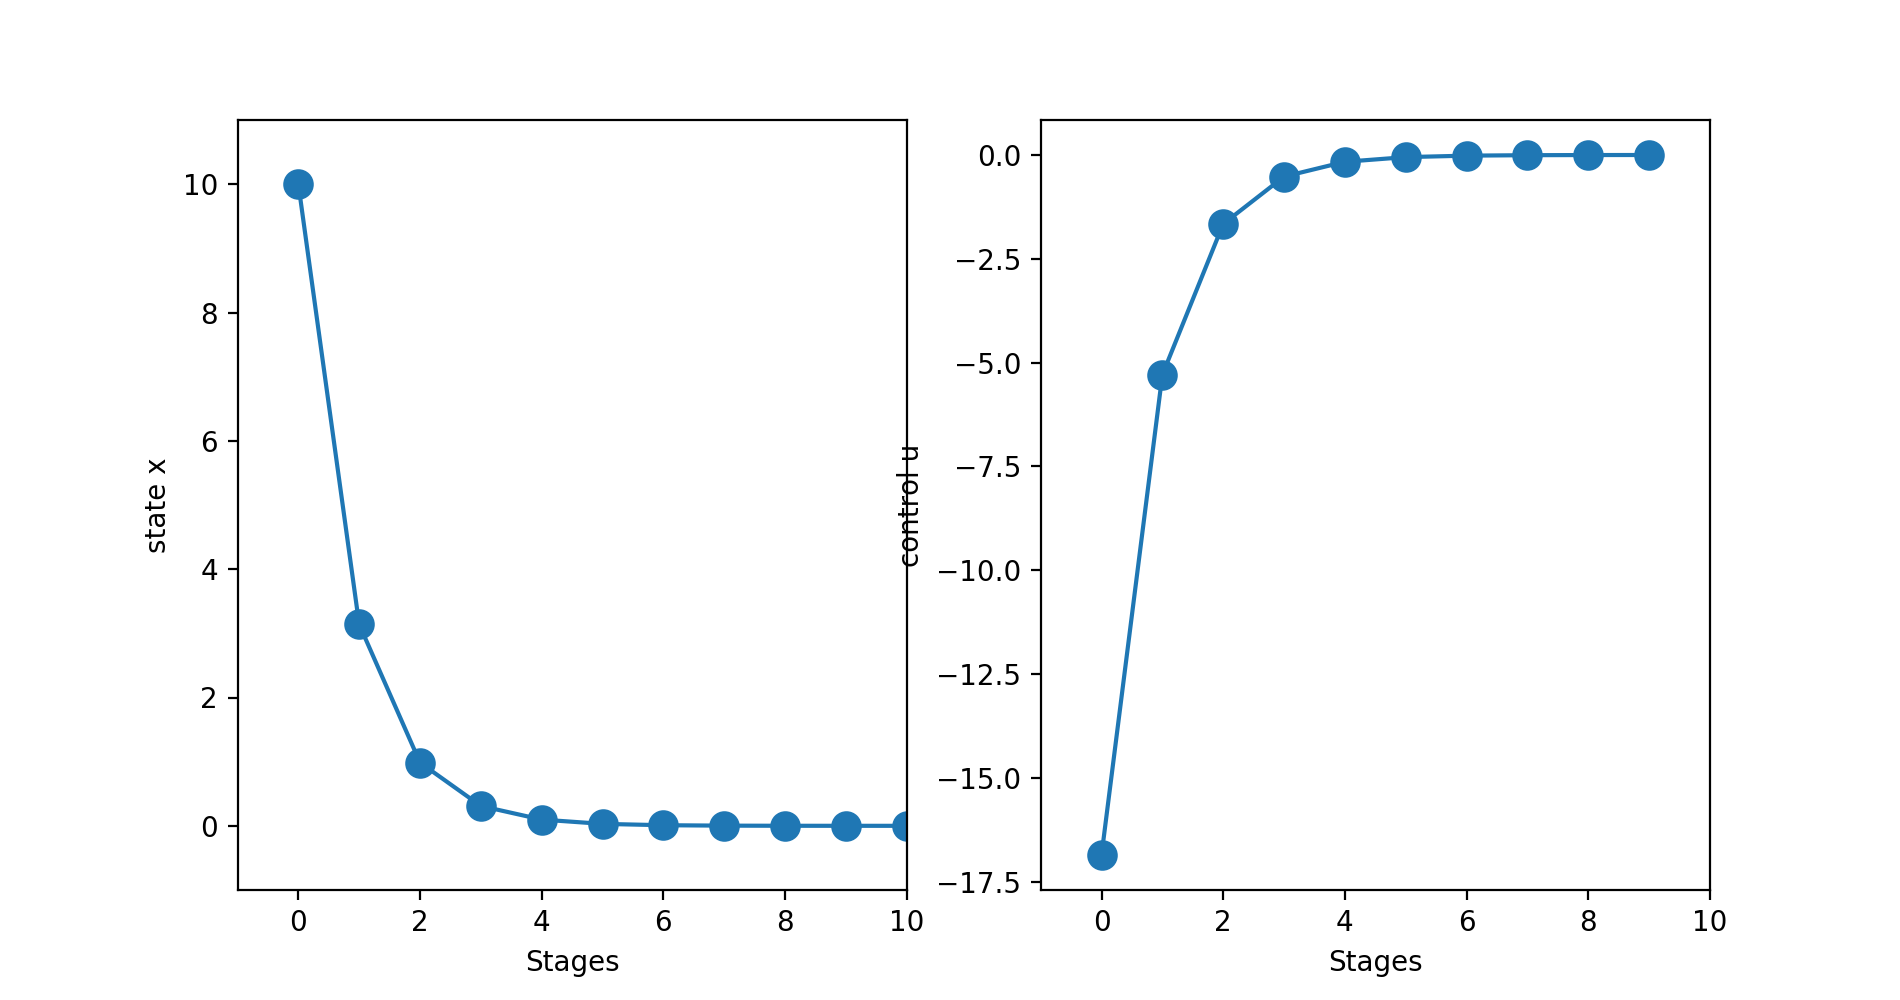

(-1, 10)

In [26]:
x0 = np.array([10.])
x,u = simulate_dynamics(x0, A, B, K, horizon_length)

# we can plot the computed gain
plt.figure(figsize=[9.5,5])
plt.subplot(1,2,1)
plt.plot(x.T,'-o', markersize=10)
plt.xlim([-1, horizon_length])
plt.ylim([-1,11])
plt.xlabel('Stages')
plt.ylabel('state x')

plt.subplot(1,2,2)
plt.plot(u.T,'-o', markersize=10)
#plt.ylim([0,10])
plt.xlabel('Stages')
plt.ylabel('control u')
plt.xlim([-1, horizon_length])


we can also compute the actual cost and compare to the predicted cost to go

In [27]:
# actual cost
cost = 0.
for i in range(horizon_length-1):
    cost += 2*x[0,i]**2 + u[0,i]**2
cost += 2*x[0,-1]**2

print('the cost of using the computed control is ' + str(cost))

predicted_cost = x0*P[0]*x0
print('the predicted cost is ' + str(predicted_cost[0,0]))

print('which is what we expected!')

the cost of using the computed control is 537.2281318277942
the predicted cost is 537.2281322566405
which is what we expected!


We can now do the same for other cost functions. We will in particular look at
$$\sum_{n=0}^{9} 100x_n^2 + u_n^2 + 100x_{10}^2$$ and 
$$\sum_{n=0}^{9} x_n^2 + 1000u_n^2 + x_{10}^2$$

<IPython.core.display.Javascript object>


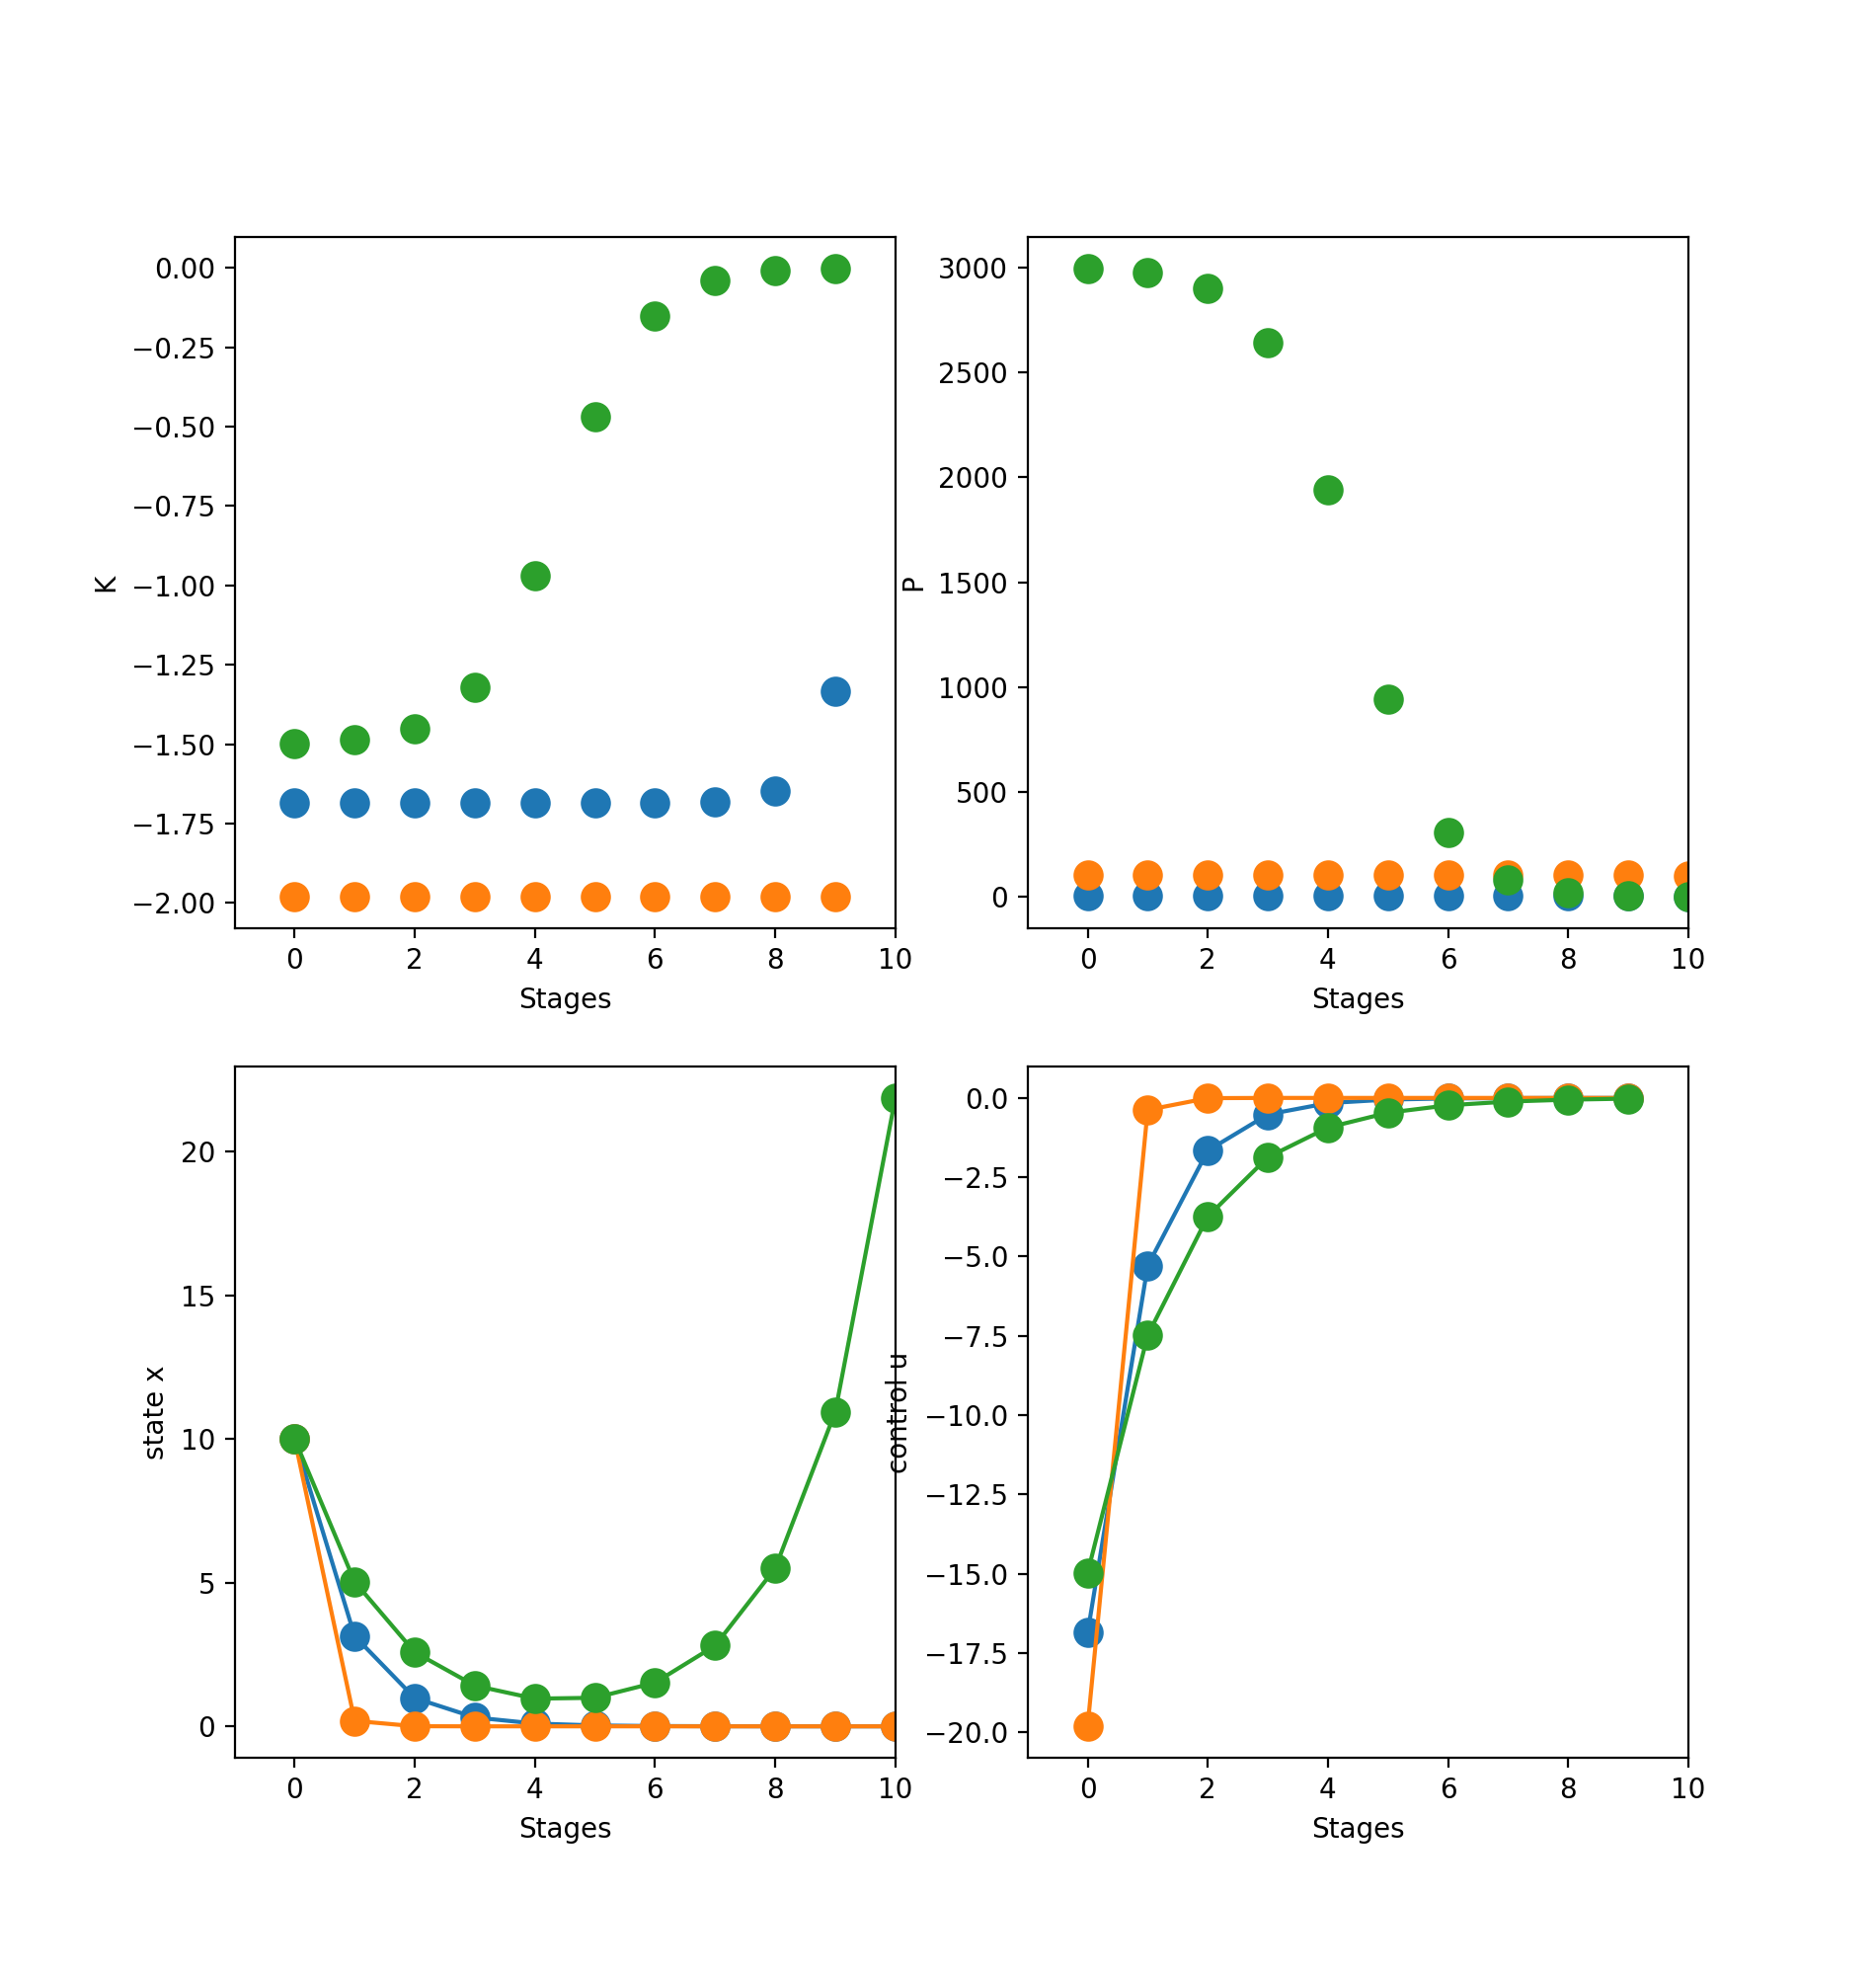

Text(0, 0.5, 'control u')

In [38]:
Q_list = [np.array([[2.]]), np.array([[100.]]), np.array([[1.]])]
R_list = [np.array([[1.]]), np.array([[1.]]), np.array([[1000.]])]

horizon_length = 10

fig, axs = plt.subplots(2,2,figsize=[9.5,10])
color = ['ob','or','og']

for Q,R in zip(Q_list, R_list):
    # we find the optimal control
    P,K = solve_ricatti_equations(A,B,Q,R,horizon_length)

    # we can plot the computed gain
    axs[0,0].plot(np.array(K).flatten(),'o', markersize=10)
    
    # we also plot P
    axs[0,1].plot(np.array(P).flatten(),'o', markersize=10)
    
    x0 = np.array([10.])
    x,u = simulate_dynamics(x0, A, B, K, horizon_length)

    # we can plot the computed gain
    axs[1,0].plot(x.T,'-o', markersize=10)

    axs[1,1].plot(u.T,'-o', markersize=10)
    
for i in range(2):
    for j in range(2):
        axs[i,j].set_xlabel('Stages')
        axs[i,j].set_xlim([-1, horizon_length])
    
axs[0,0].set_ylabel('K')
axs[0,1].set_ylabel('P')
axs[1,0].set_ylabel('state x')
axs[1,1].set_ylabel('control u')

We can also look at the effect of the horizon length. For example, if we use $N=50$

<IPython.core.display.Javascript object>


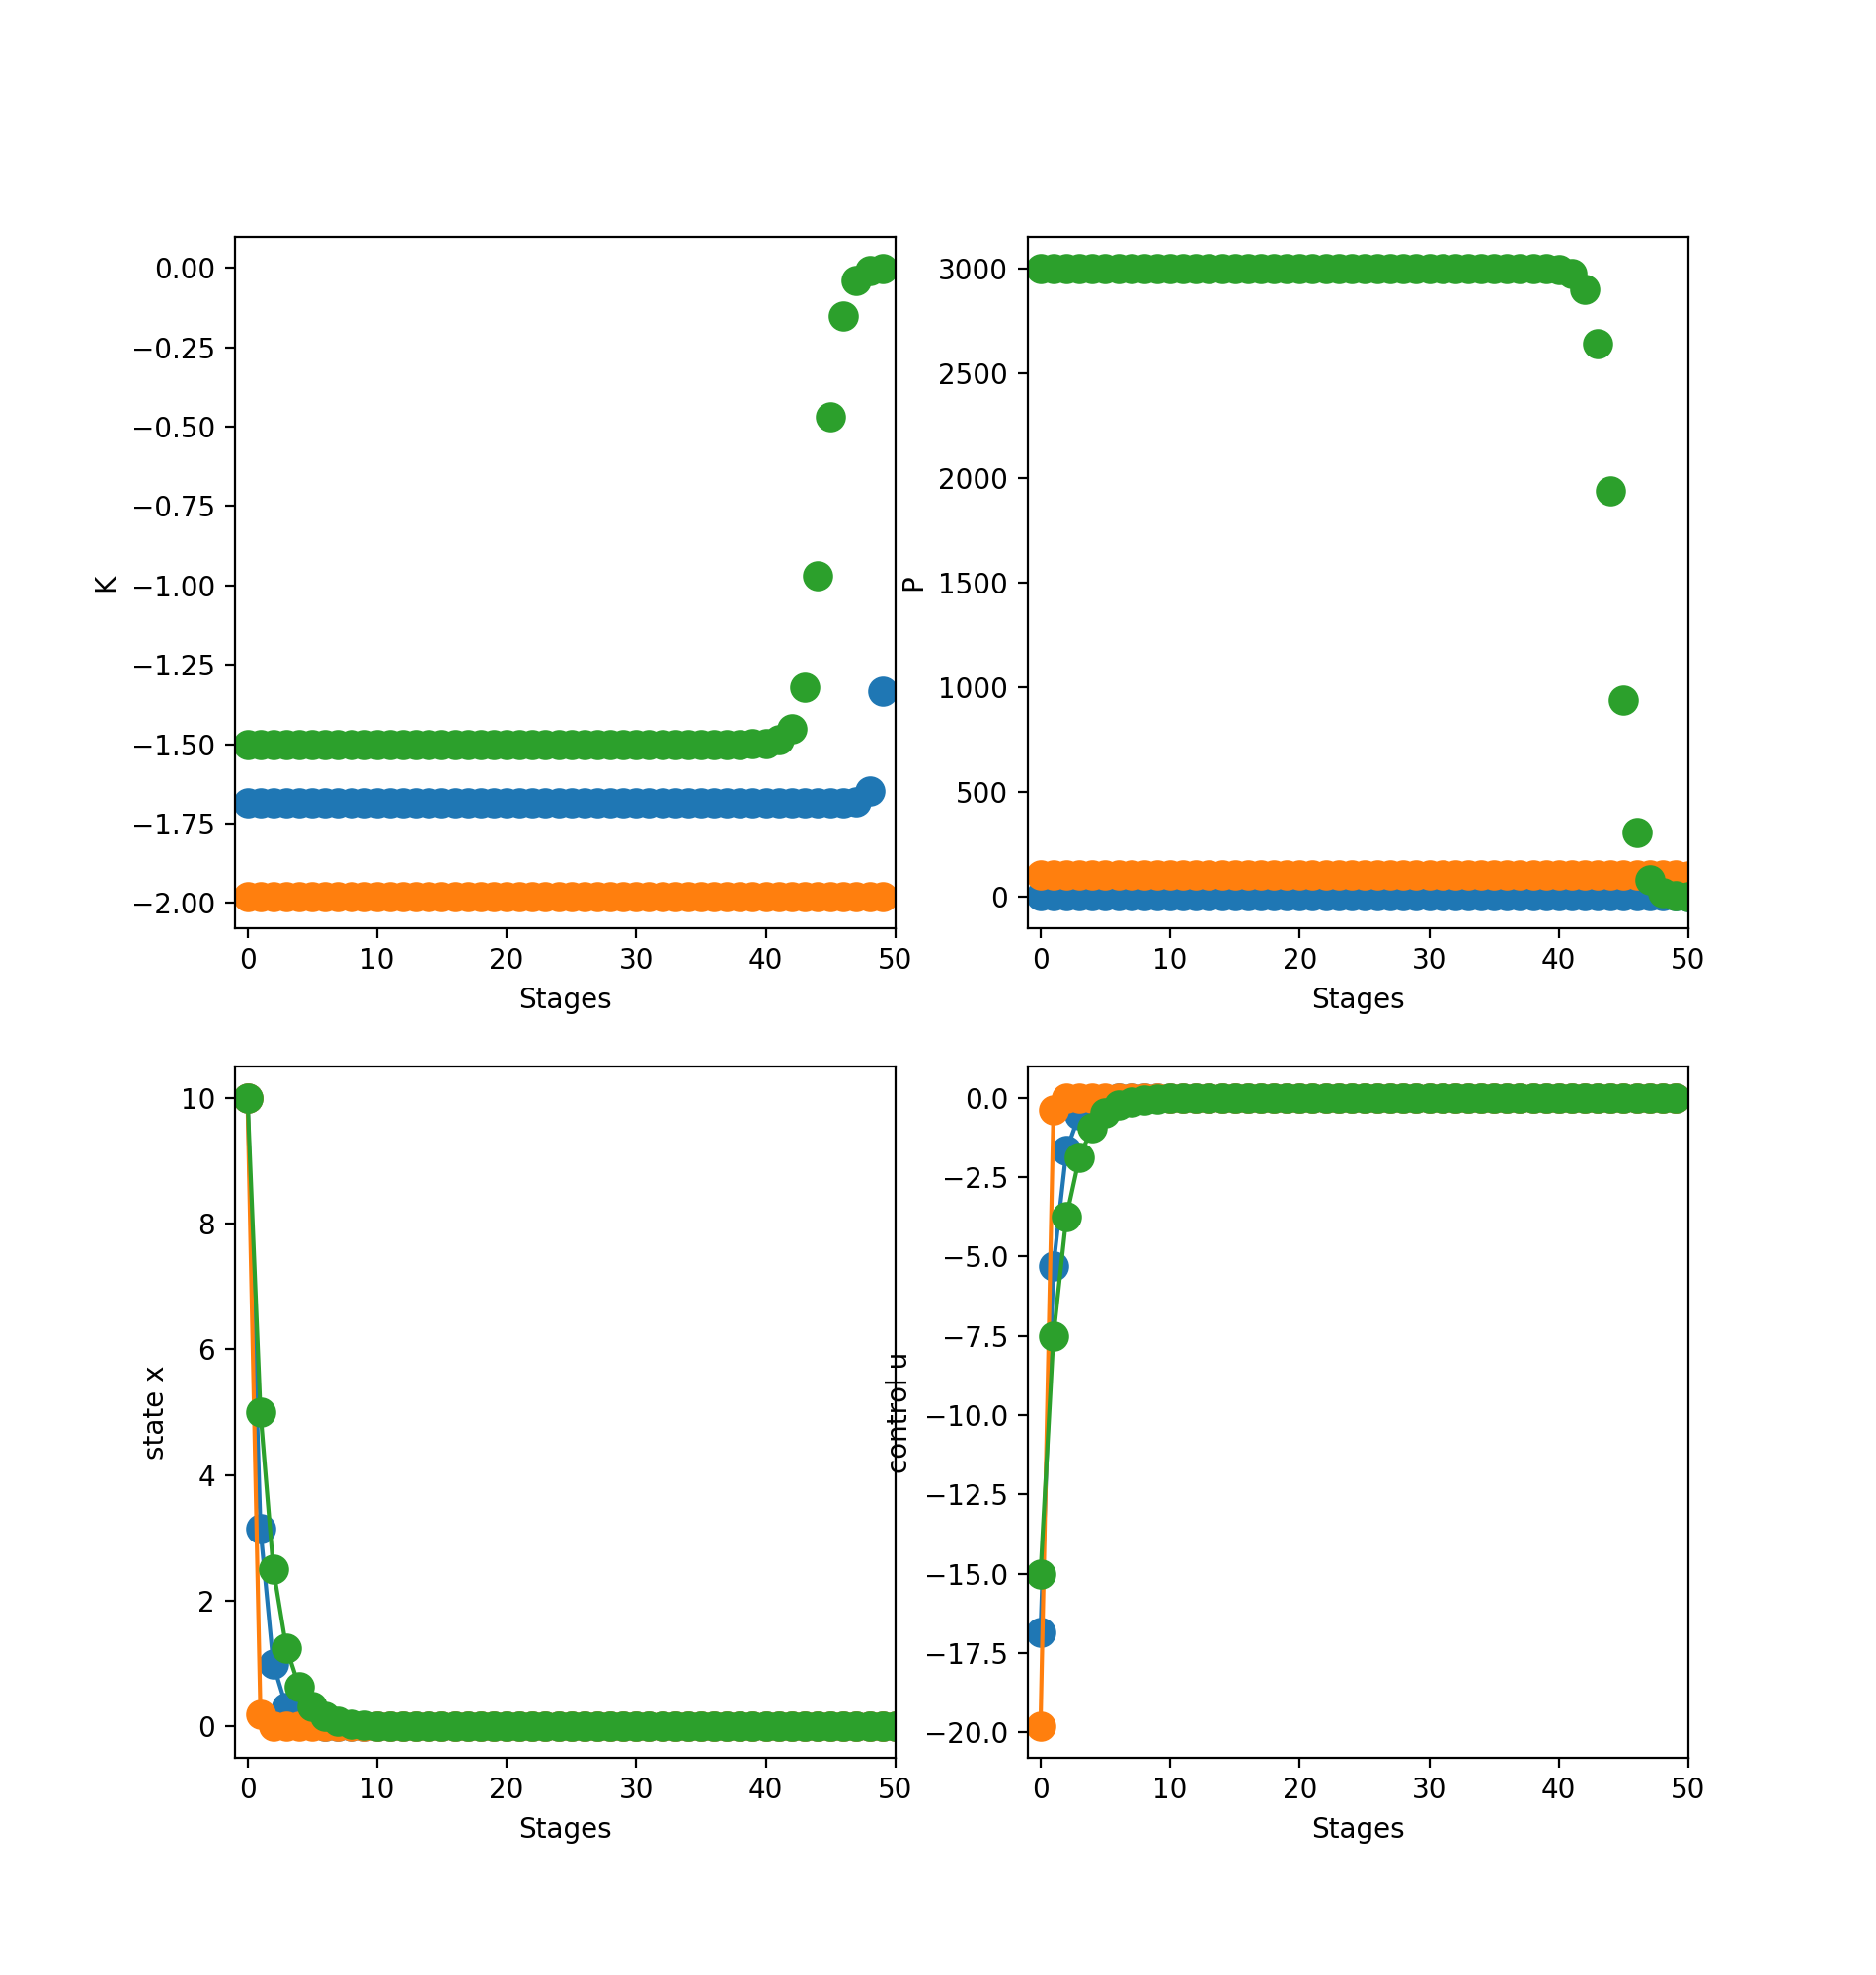

Text(0, 0.5, 'control u')

In [41]:
Q_list = [np.array([[2.]]), np.array([[100.]]), np.array([[1.]])]
R_list = [np.array([[1.]]), np.array([[1.]]), np.array([[1000.]])]

horizon_length = 50

fig, axs = plt.subplots(2,2,figsize=[9.5,10])
color = ['ob','or','og']

for Q,R in zip(Q_list, R_list):
    # we find the optimal control
    P,K = solve_ricatti_equations(A,B,Q,R,horizon_length)

    # we can plot the computed gain
    axs[0,0].plot(np.array(K).flatten(),'o', markersize=10)
    
    # we also plot P
    axs[0,1].plot(np.array(P).flatten(),'o', markersize=10)
    
    x0 = np.array([10.])
    x,u = simulate_dynamics(x0, A, B, K, horizon_length)

    # we can plot the computed gain
    axs[1,0].plot(x.T,'-o', markersize=10)

    axs[1,1].plot(u.T,'-o', markersize=10)
    
for i in range(2):
    for j in range(2):
        axs[i,j].set_xlabel('Stages')
        axs[i,j].set_xlim([-1, horizon_length])
    
axs[0,0].set_ylabel('K')
axs[0,1].set_ylabel('P')
axs[1,0].set_ylabel('state x')
axs[1,1].set_ylabel('control u')

## Example: controlling a simplified car model
We show how we can get simplified model of our car dynamics to reach position 0 using the LQR controller
The dynamics of the car is
$$ \dot{x} = v \\ \dot{v} = a$$
which we discretize using a time step $\Delta t$
$$ x_{n+1} = x_n + v_n \Delta t\\ v_{n+1} = v_n + a_n \Delta t$$
which is written in matrix form
$$ \begin{bmatrix}x_{n+1} \\ v_{n+1} \end{bmatrix} = \begin{bmatrix} 1 & \Delta t \\ 0 & 1 \end{bmatrix} \begin{bmatrix}x_{n} \\ v_{n} \end{bmatrix} + \begin{bmatrix} 0 \\ \Delta t \end{bmatrix} a_n $$

So we have $$\mathbf{A} = \begin{bmatrix} 1 & \Delta t \\ 0 & 1 \end{bmatrix}$$ and $$\mathbf{B} = \begin{bmatrix} 0 \\ \Delta t \end{bmatrix}$$

In [11]:
# we define the dynamics
Delta_t = 0.01
A = np.array([[1.,Delta_t],[0,1]])
B = np.array([[0],[Delta_t]])

We now define a quadratic cost function

In [12]:
# we define the cost matrices Q and R
Q = np.array([[1000.,0],[0,10.]])
R = np.array([10.])

# and the horizon length of 10 seconds (10/Delta_t)
horizon = 1000

In [13]:
# we find the optimal control
P,K = solve_ricatti_equations(A,B,Q,R,horizon)

# we integrate the dynamics with the controller from x0 = [10,0]
# which means the car is stopped and starts 10m away from the goal
x0 = np.array([10.,0])
x,u = simulate_dynamics(x0, A, B, K, horizon)

<IPython.core.display.Javascript object>


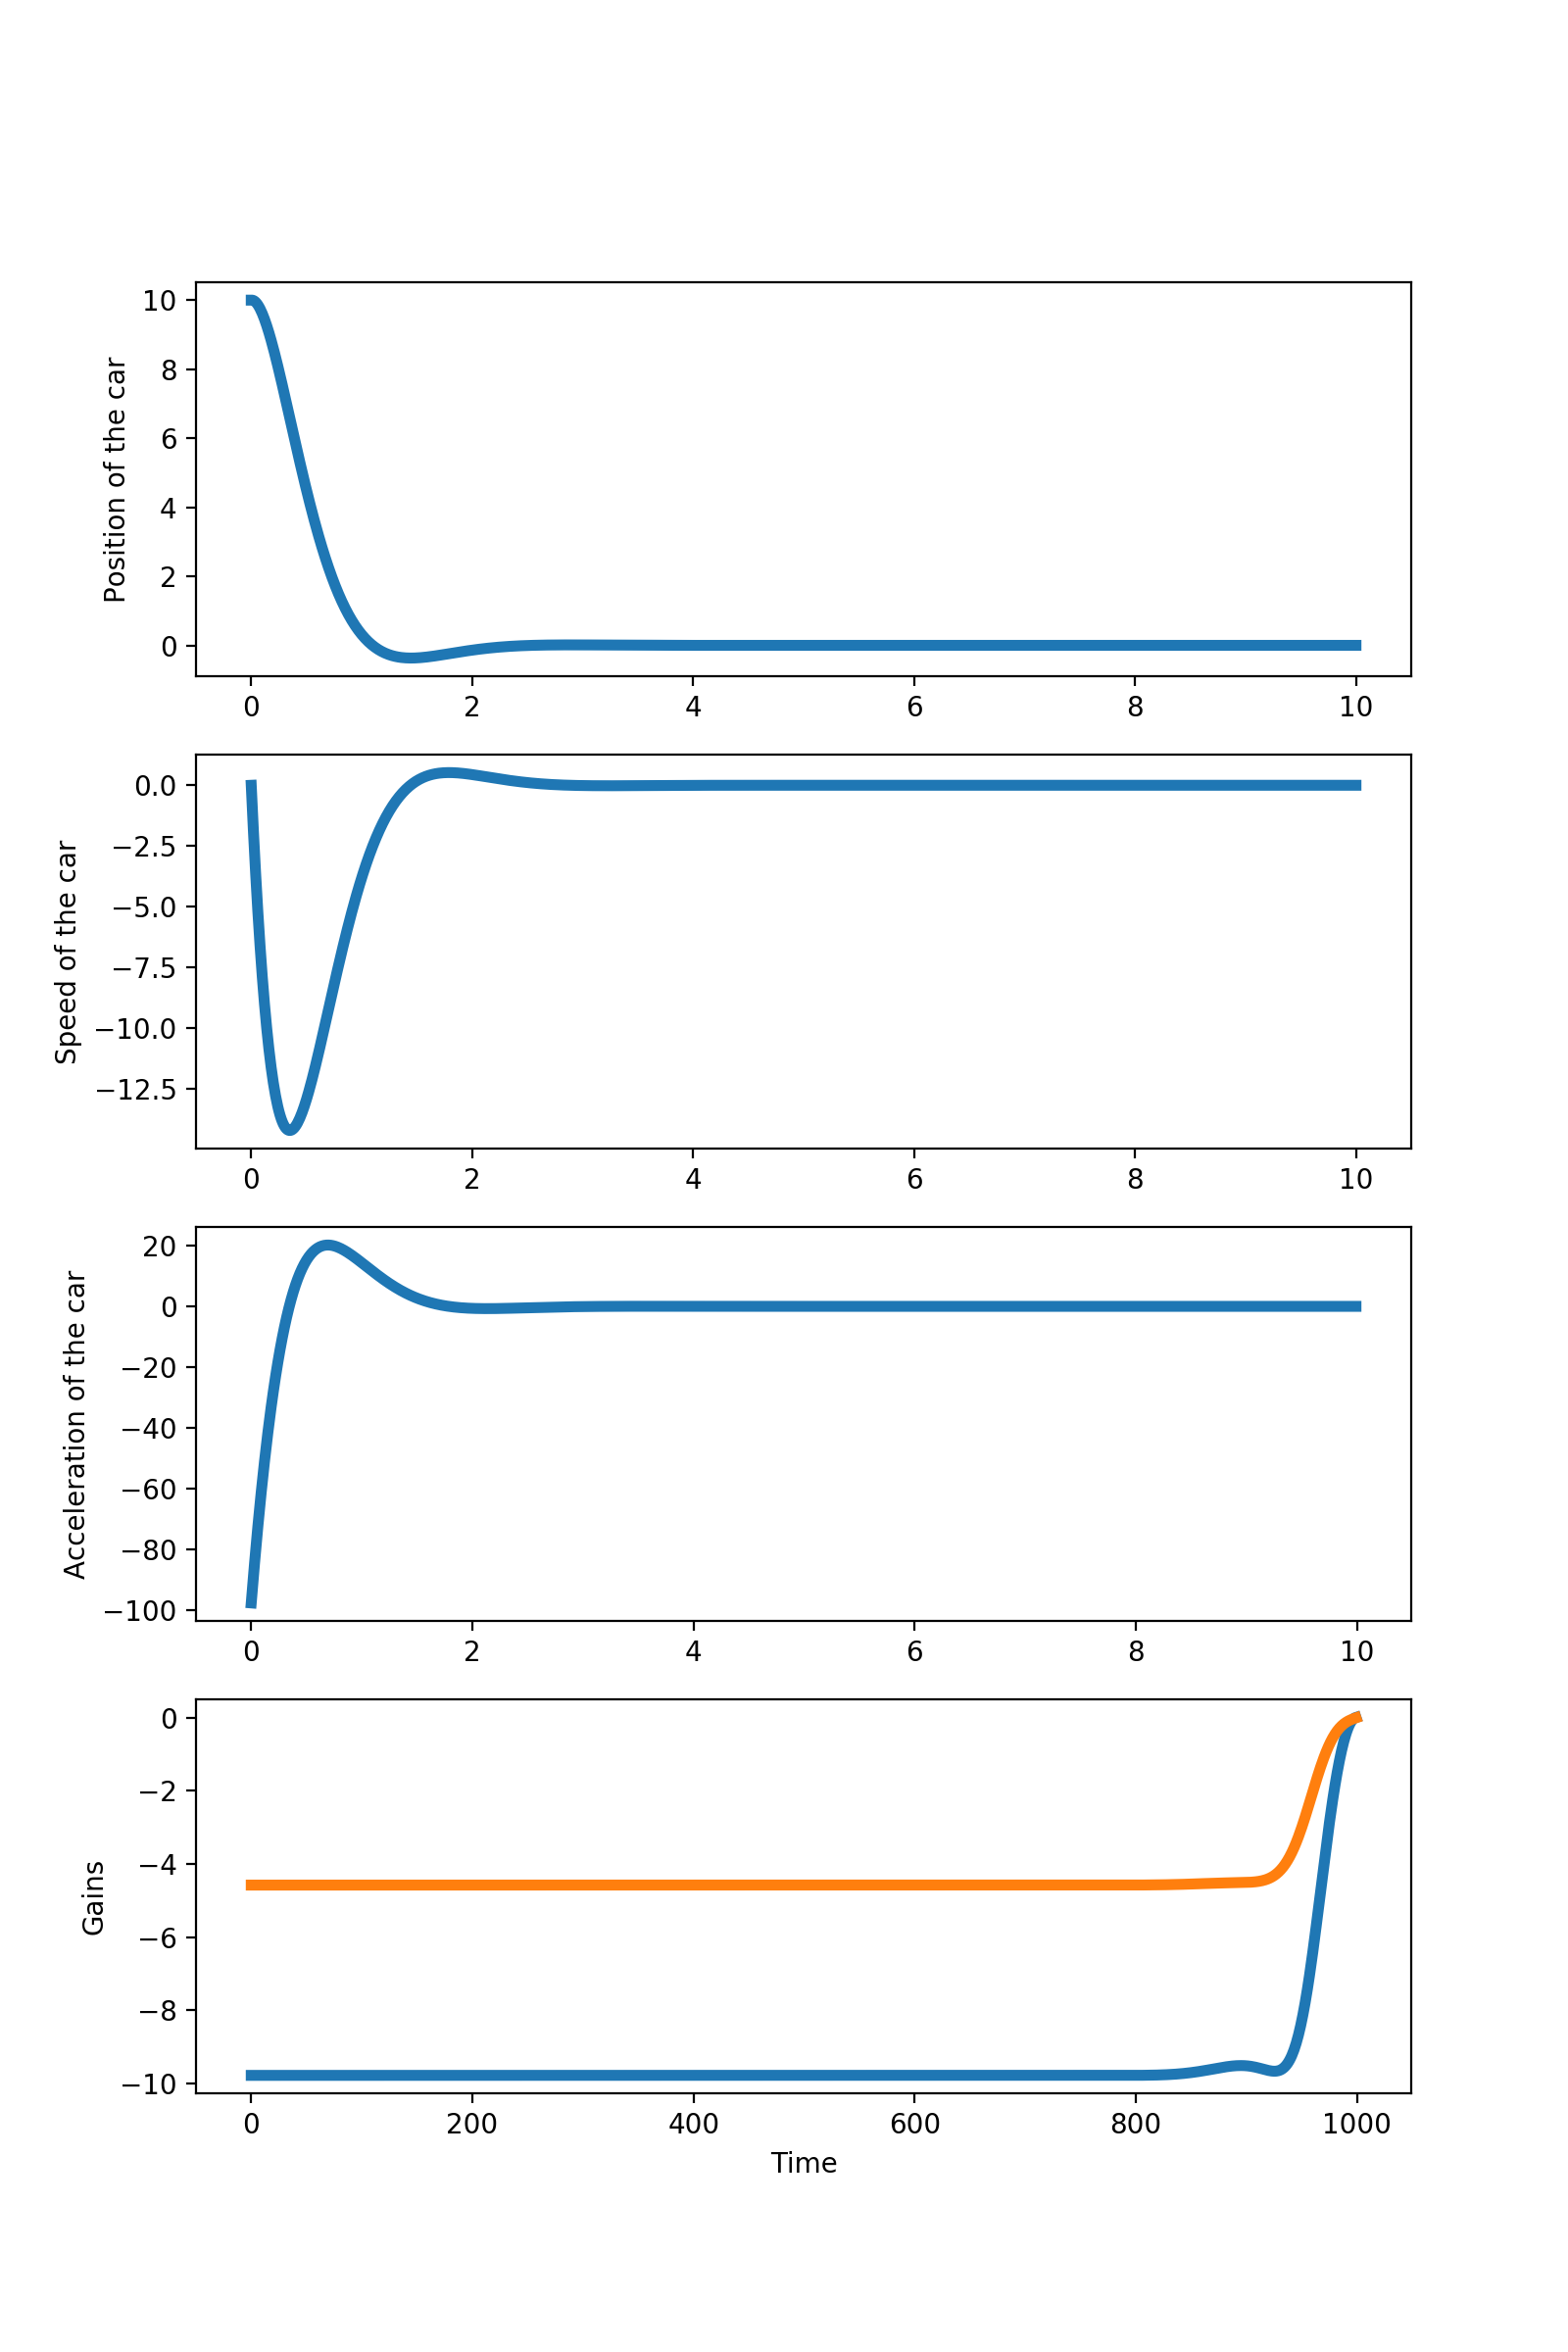

In [14]:
def plot_results(x,K,u,horizon_length):
    """
    utility function to plot the simulation results
    """
    t = np.array(range(horizon+1))*Delta_t
    plt.figure(figsize=[8, 12])
    plt.subplot(4,1,1)
    plt.plot(t, x[0,:], linewidth=4)
    plt.ylabel('Position of the car')

    plt.subplot(4,1,2)
    plt.plot(t, x[1,:], linewidth=4)
    plt.ylabel('Speed of the car')

    plt.subplot(4,1,3)
    plt.plot(t[:-1], u[0,:], linewidth=4)
    plt.ylabel('Acceleration of the car')

    # in this subplot we show all the gains as a function of time
    plt.subplot(4,1,4)
    plt.plot([np.ndarray.flatten(k) for k in K], linewidth=4)
    plt.ylabel('Gains')
    plt.xlabel('Time')

plot_results(x, K, u, horizon)


We can also change the cost matrices to penalize more the speed of the car

<IPython.core.display.Javascript object>


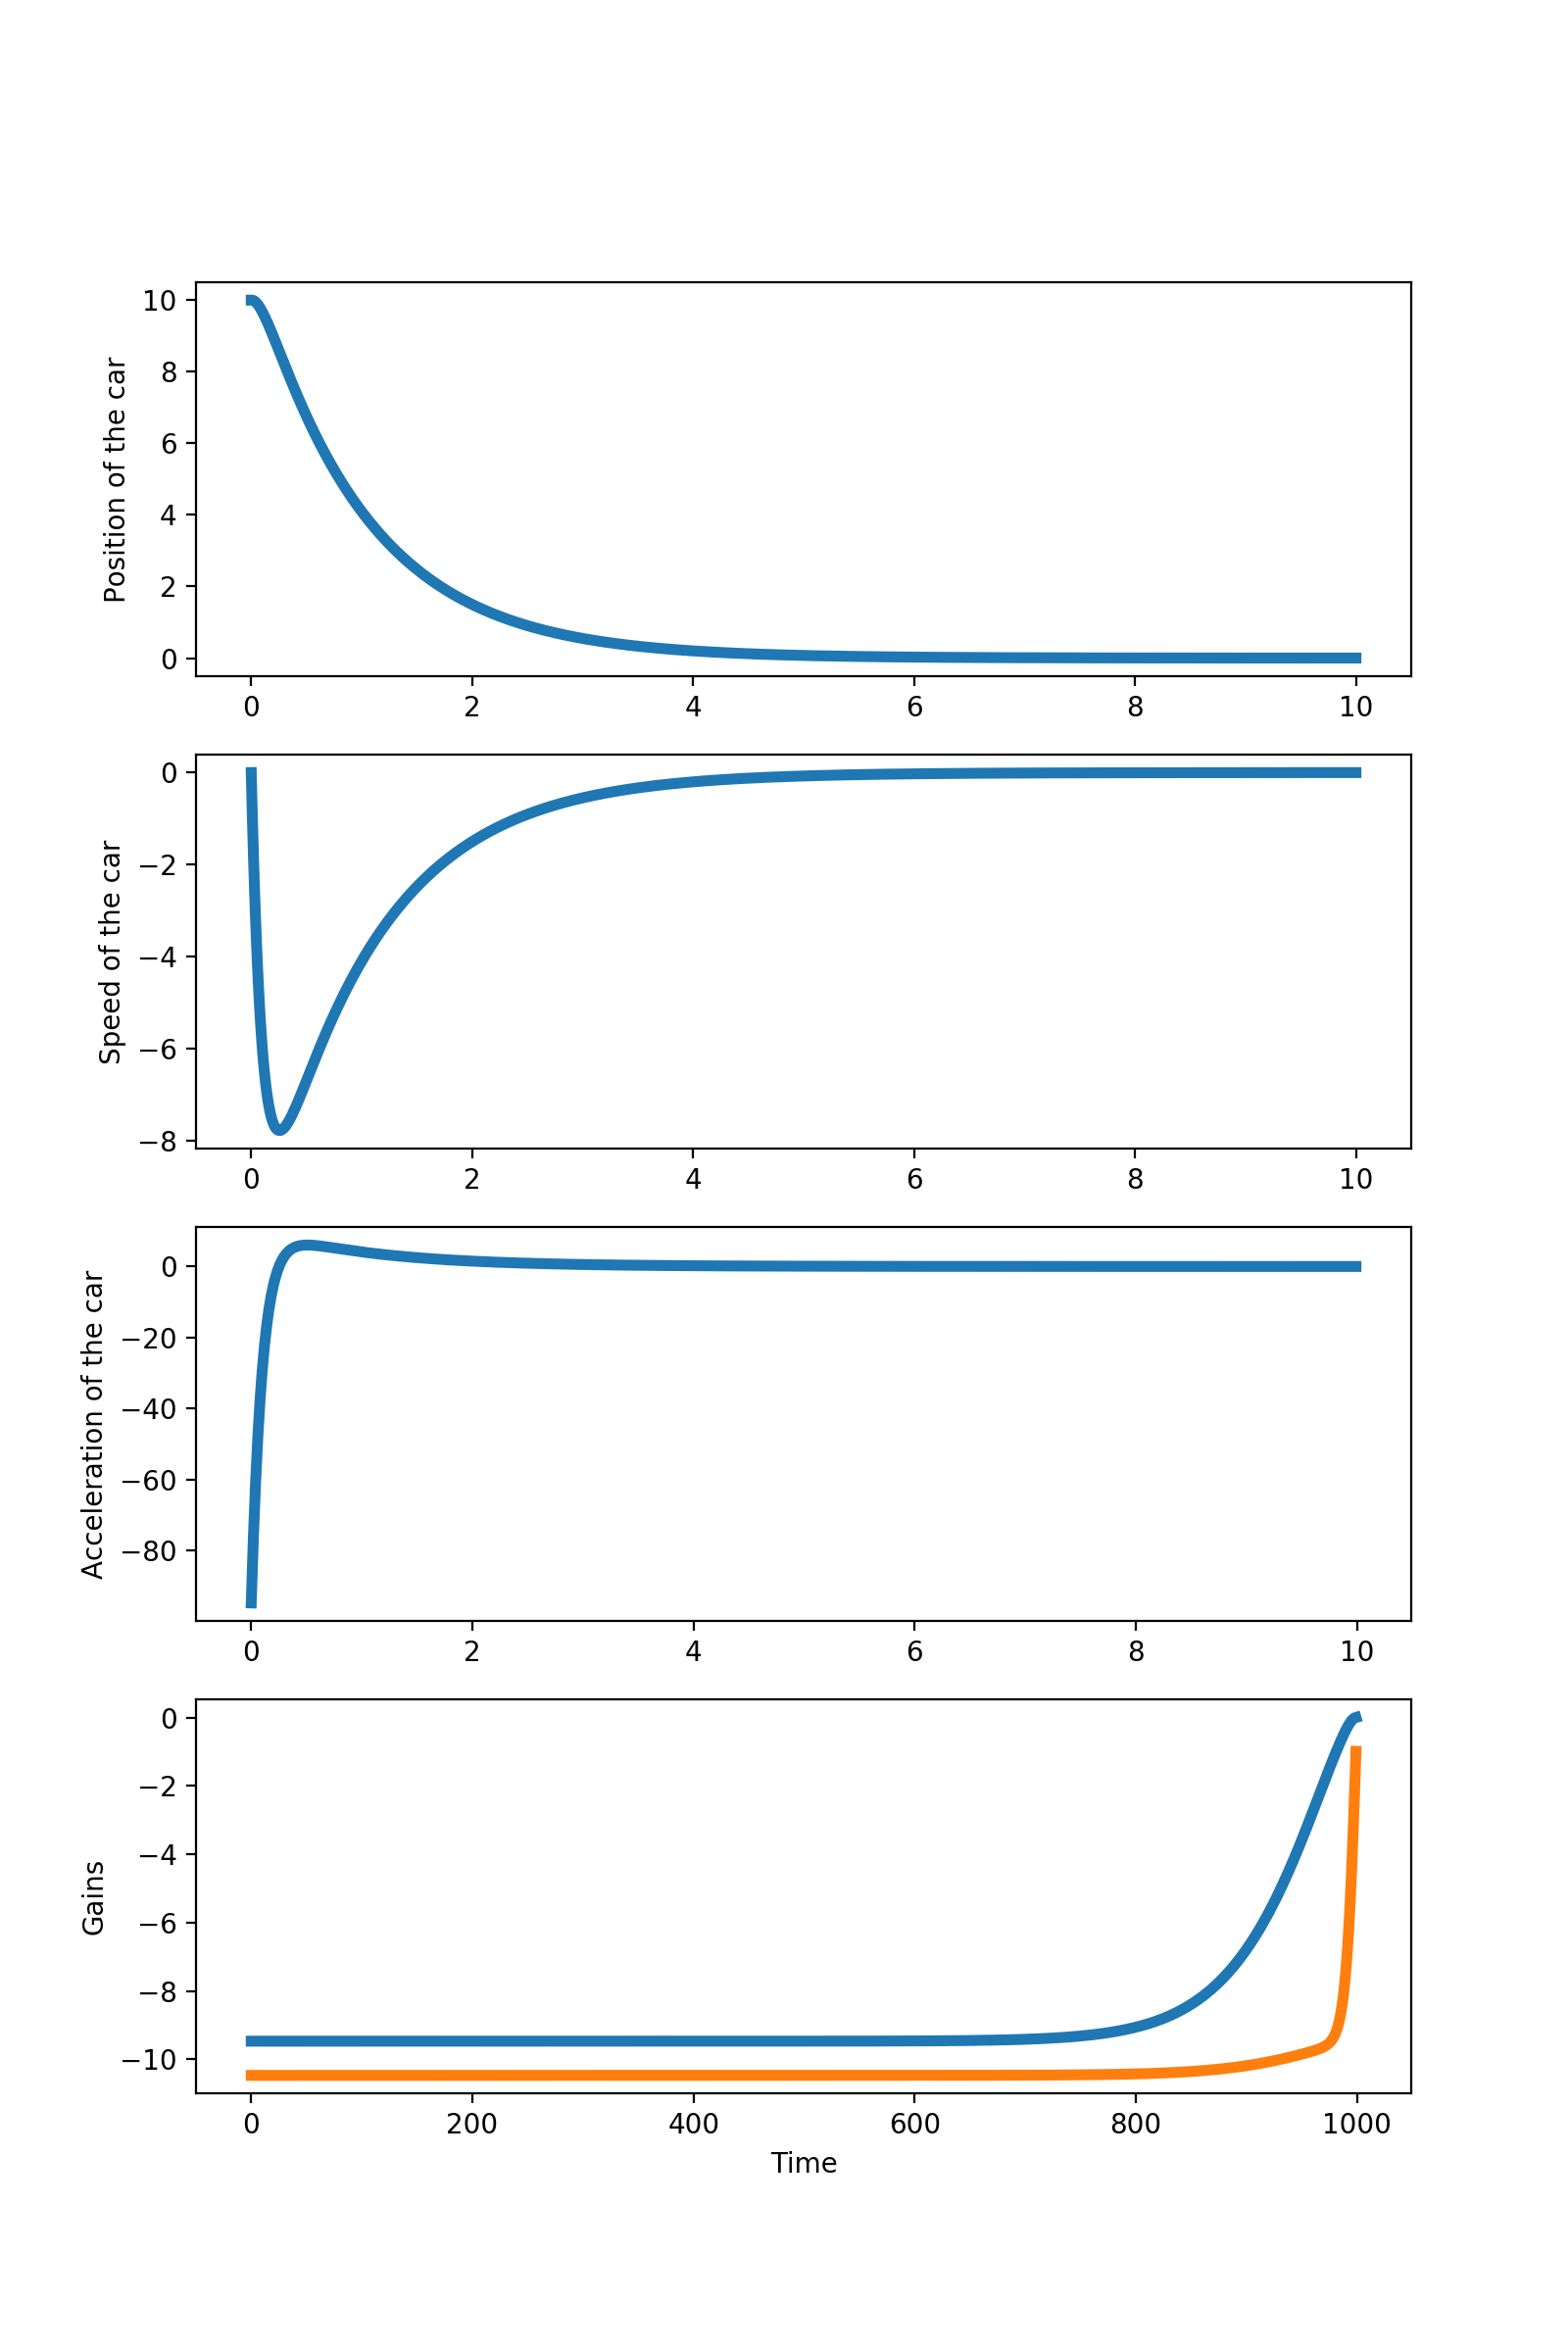

In [15]:
# we change the cost matrices, penalizing more the speed of the car
Q = np.array([[1000.,0],[0,1000.]])
R = np.array([10.])

# and the horizon length of 10 seconds (10/Delta_t)
horizon = 1000

# we find the optimal control
P,K = solve_ricatti_equations(A,B,Q,R,horizon)

# we integrate the dynamics with the controller from x0 = [10,0]
# which means the car is stopped and starts 10m away from the goal
x0 = np.array([10.,0])
x,u = simulate_dynamics(x0, A, B, K, horizon)

plot_results(x, K, u, horizon)

we change the cost matrices, increasing the penality on acceleration

<IPython.core.display.Javascript object>


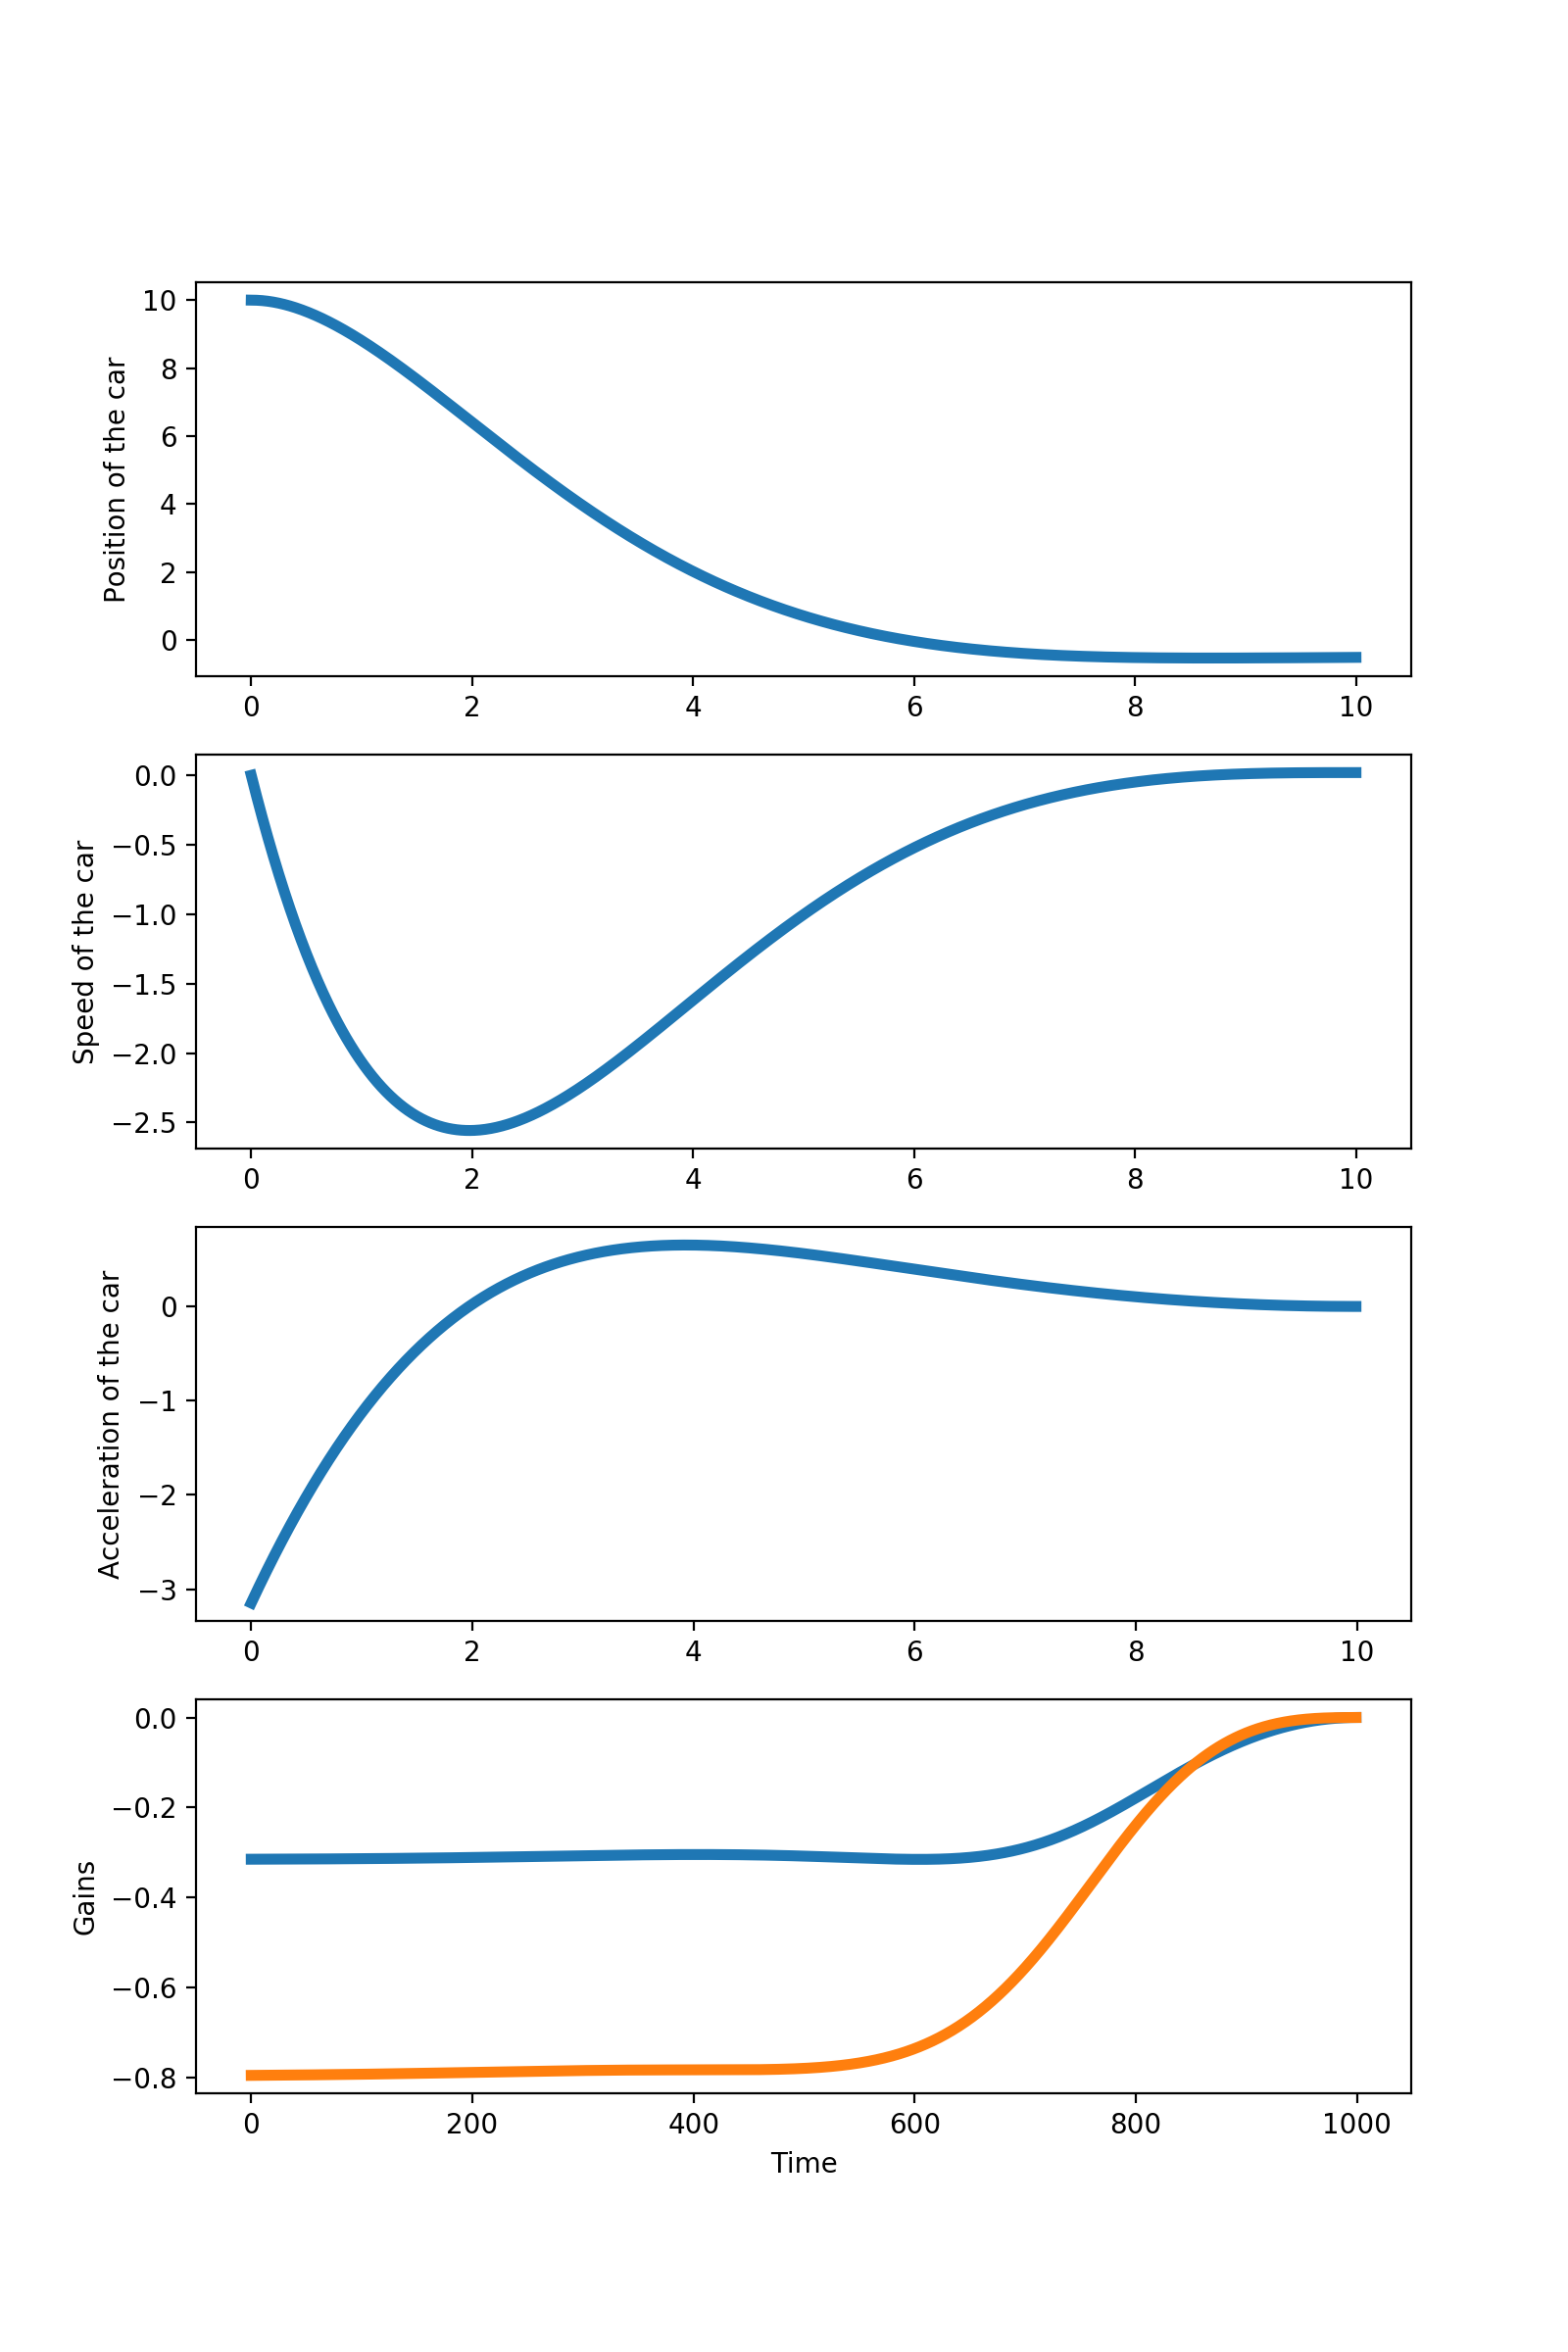

In [16]:
# we change the cost matrices, increasing the penality on acceleration
Q = np.array([[1000.,0],[0,10.]])
R = np.array([10000.])

# and the horizon length of 10 seconds (10/Delta_t)
horizon = 1000

# we find the optimal control
P,K = solve_ricatti_equations(A,B,Q,R,horizon)

# we integrate the dynamics with the controller from x0 = [10,0]
# which means the car is stopped and starts 10m away from the goal
x0 = np.array([10.,0])
x,u = simulate_dynamics(x0, A, B, K, horizon)

plot_results(x, K, u, horizon)